In [ ]:
from bloqade import qasm2
import numpy as np
from bloqade.pyqrack import PyQrack
from collections import Counter
from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin import ir
from kirin.rewrite import Walk
from bloqade.qasm2.passes import UOpToParallel, QASM2Fold
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("../src/TimeIndepSpinChain/")
from TimeIndepSpinChain import (
    SpinChainLieTrotter, SpinChainLieTrotterParallel, SpinChainSuzukiTrotter,
    extended_opt, SpinChainLieTrotterUnopt, unopt,  SpinChainSuzukiTrotter
)

# O(n^2) Trotterization

In [2]:
time_interval = 0.5
steps = 24
N = 2
no_noise_2_qubits_lie = [] 

for i in range(steps):
    kernel_PT = SpinChainLieTrotter(N, time_interval*i, i)
    
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results = device.multi_run(kernel_PT, _shots=100)
    
    def to_bitstrings(results):
        return Counter(map(lambda result:"".join(map(str, result)), results))
    
    counts = to_bitstrings(results)
    
    total_magnetization = 0
    
    for key, value in counts.items():
        spin_down = str(key).count('1')
        total_magnetization += value*spin_down * (-1) + value*(2**N - spin_down)

    print("Time " + str(time_interval*i) + ": " + str(total_magnetization/100))
    no_noise_2_qubits_lie.append(total_magnetization/100) 



 No platforms found. Check OpenCL installation!
Time 0.0: 4.0
Time 0.5: 1.48
Time 1.0: -2.94
Time 1.5: -3.26
Time 2.0: 0.12
Time 2.5: 2.98
Time 3.0: 1.92
Time 3.5: -0.72
Time 4.0: -2.58
Time 4.5: -0.52
Time 5.0: 1.3
Time 5.5: 0.54
Time 6.0: -0.02
Time 6.5: -0.54
Time 7.0: -0.76
Time 7.5: 0.04
Time 8.0: -0.74
Time 8.5: 0.02
Time 9.0: 0.84
Time 9.5: 0.52
Time 10.0: -0.64
Time 10.5: -1.32
Time 11.0: 0.14
Time 11.5: 0.66


In [ ]:
time_interval = 0.5
steps = 24
N = 3
mag_vals = [] 

for i in range(steps):
    kernel_PT = SpinChainLieTrotter(N, time_interval*i, i)
    
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results = device.multi_run(kernel_PT, _shots=100)
    
    def to_bitstrings(results):
        return Counter(map(lambda result:"".join(map(str, result)), results))
    
    counts = to_bitstrings(results)
    
    total_magnetization = 0
    
    for key, value in counts.items():
        spin_down = str(key).count('1')
        total_magnetization += value*spin_down * (-1) + value*(2**N - spin_down)

    print("Time " + str(time_interval*i) + ": " + str(total_magnetization/100))
    mag_vals.append(total_magnetization/100) 



Time 0.0: 8.0
Time 0.5: 2.4
Time 1.0: -5.1
Time 1.5: -6.7
Time 2.0: 0.58
Time 2.5: 6.4
Time 3.0: 3.9
Time 3.5: -2.5
Time 4.0: -4.64
Time 4.5: -0.82
Time 5.0: 1.92
Time 5.5: 3.2
Time 6.0: -0.14
Time 6.5: -2.88
Time 7.0: -0.92
Time 7.5: 0.94
Time 8.0: 1.58
Time 8.5: 0.68
Time 9.0: 0.4
Time 9.5: -1.44
Time 10.0: -0.52
Time 10.5: 0.06
Time 11.0: -0.76
Time 11.5: -0.06


In [ ]:
from rich.console import Console
target = qasm2.emit.QASM2(allow_parallel=False, allow_global=False) 
ast = target.emit(SpinChainLieTrotter(2,12,24, parallelize=False)) 
qasm_str: str = qasm2.parse.spprint(ast, console=Console(no_color=True))

open("output.txt","w").write(qasm_str) # not fully functional


In [26]:
noNoise8QLie = np.array([8.0,2.4,-5.1,-6.7,0.58,6.4,3.9,-2.5,-4.64,-0.82,1.92,3.2,-0.14,-2.88,-0.92,0.94,1.58,0.68,0.4,-1.44,-0.52,0.06,-0.76,-0.06])

In [ ]:
plt.figure(figsize=(10, 4))
t = np.linspace(0, (steps-1)*time_interval, 48)
noNoise8QLie = np.array(mag_vals)
plt.plot(t, noNoise8QLie, marker="x", c="darkmagenta", ls="dashed", lw=0.8)
plt.xlabel("Time (a.u.)")
plt.ylabel(r"$\langle M \rangle$")
plt.title("1D Ising chain magnetization over time on Bloqade (8 qubits, no noise, O(t^2))") 

### With noise

In [3]:
from bloqade.qasm2.passes import NoisePass
from bloqade.noise import native

# add noise
time_interval = 0.5
steps = 24
N = 2
with_noise_mag = [] 

for i in range(steps):
    kernel_PT = SpinChainLieTrotterUnopt(N, time_interval*i, i)
    noise_kernel = kernel_PT.similar()
    unopt.run_pass(noise_kernel, parallelize=True)
    NoisePass(unopt)(noise_kernel)
    noise_kernel = noise_kernel.similar(unopt.add(native))

    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results = device.multi_run(kernel_PT, _shots=100)
    
    def to_bitstrings(results):
        return Counter(map(lambda result:"".join(map(str, result)), results))
    
    counts = to_bitstrings(results)
    
    total_magnetization = 0
    
    for key, value in counts.items():
        spin_down = str(key).count('1')
        total_magnetization += value*spin_down * (-1) + value*(2**N - spin_down)

    print("Time " + str(time_interval*i) + ": " + str(total_magnetization/100))
    with_noise_mag.append(total_magnetization/100) 


AttributeError: 'function' object has no attribute 'similar'

In [ ]:
from bloqade.qasm2.passes import NoisePass
from bloqade.noise import native

# add noise
time_interval = 0.5
steps = 24
N = 2
with_noise_mag_unopt = [] 

for i in range(steps):
    kernel_PT = SpinChainLieTrotter(N, time_interval*i, i)
    noise_kernel = kernel_PT.similar()
    #extended_opt.run_pass(noise_kernel, parallelize=True)
    NoisePass(extended_opt)(noise_kernel)
    noise_kernel = noise_kernel.similar(extended_opt.add(native))

    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results = device.multi_run(kernel_PT, _shots=100)
    
    def to_bitstrings(results):
        return Counter(map(lambda result:"".join(map(str, result)), results))
    
    counts = to_bitstrings(results)
    
    total_magnetization = 0
    
    for key, value in counts.items():
        spin_down = str(key).count('1')
        total_magnetization += value*spin_down * (-1) + value*(2**N - spin_down)

    print("Time " + str(time_interval*i) + ": " + str(total_magnetization/100))
    with_noise_mag_unopt.append(total_magnetization/100) 


Text(0.5, 1.0, '1D Ising chain magnetization over time on Bloqade noiseless vs noisy (4 qubits, O(t^2))')

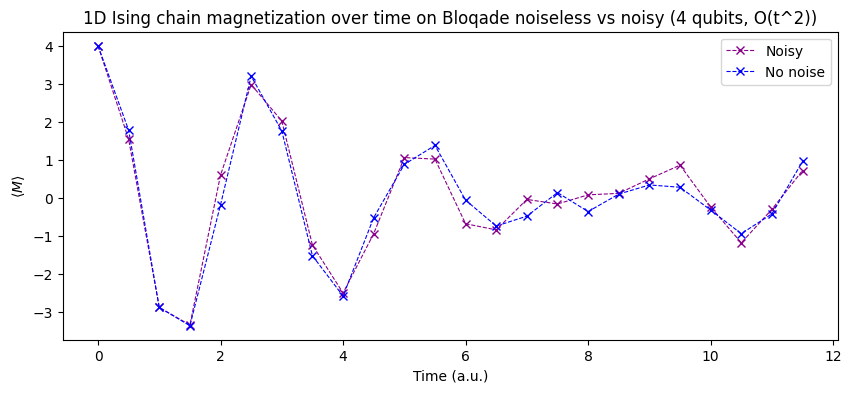

In [ ]:
plt.figure(figsize=(10, 4))
t = np.linspace(0, (steps-1)*time_interval, 24)
plt.plot(t, with_noise_mag, marker="x", c="darkmagenta", ls="dashed", lw=0.8, label="Noisy parallel")
plt.plot(t, no_noise_2_qubits_lie, marker="x", c="blue", ls="dashed", lw=0.8, label="No noise")
plt.xlabel("Time (a.u.)")
plt.ylabel(r"$\langle M \rangle$")
plt.legend()
plt.title("1D Ising chain magnetization over time on Bloqade noiseless vs noisy (4 qubits, O(t^2))") 

# Better Trotterization

#### Test on 4 Qubits

In [ ]:
time_interval = 0.5
steps = 24
N = 2
mag_vals = [] 

for i in range(steps):
    kernel_PT = SpinChainSuzukiTrotter(N, time_interval*i, i)
    
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results = device.multi_run(kernel_PT, _shots=100)
    
    def to_bitstrings(results):
        return Counter(map(lambda result:"".join(map(str, result)), results))
    
    counts = to_bitstrings(results)
    
    total_magnetization = 0
    
    for key, value in counts.items():
        spin_down = str(key).count('1')
        total_magnetization += value*spin_down * (-1/2) + value*(2**N - spin_down) * (1/2)

    print("Time " + str(time_interval*i) + ": " + str(total_magnetization/100))
    mag_vals.append(total_magnetization/100) 

In [ ]:
plt.figure(figsize=(10, 4))
t = np.linspace(0, (steps-1)*time_interval, 24)
noNoise8QSukuzi = np.array(mag_vals)
plt.plot(t, noNoise8QSukuzi, marker="x", c="darkmagenta", ls="dashed", lw=0.8)
plt.xlabel("Time (a.u.)")
plt.ylabel(r"$\langle M \rangle$")
plt.title("1D Ising chain magnetization over time on Bloqade (4 qubits, no noise, O(t^3))") 

In [5]:
time_interval = 0.5
steps = 24
N = 3
mag_vals = [] 

for i in range(steps):
    kernel_PT = SpinChainSuzukiTrotter(N, time_interval*i, i)
    
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results = device.multi_run(kernel_PT, _shots=100)
    
    def to_bitstrings(results):
        return Counter(map(lambda result:"".join(map(str, result)), results))
    
    counts = to_bitstrings(results)
    
    total_magnetization = 0
    
    for key, value in counts.items():
        spin_down = str(key).count('1')
        total_magnetization += value*spin_down * (-1/2) + value*(2**N - spin_down) * (1/2)

    print("Time " + str(time_interval*i) + ": " + str(total_magnetization/100))
    mag_vals.append(total_magnetization/100) 

Time 0.0: 4.0
Time 0.5: 1.53
Time 1.0: -2.68
Time 1.5: -3.54
Time 2.0: 0.15
Time 2.5: 3.03
Time 3.0: 1.86
Time 3.5: -0.59
Time 4.0: -2.35
Time 4.5: -0.63
Time 5.0: 1.23
Time 5.5: 1.71
Time 6.0: 0.28
Time 6.5: -1.34
Time 7.0: -0.73
Time 7.5: -0.55
Time 8.0: 0.37
Time 8.5: 0.07
Time 9.0: -0.27
Time 9.5: -0.6
Time 10.0: 0.08
Time 10.5: 0.49
Time 11.0: 0.66
Time 11.5: -0.22


In [25]:
noNoise8QSukuzi = 2*np.array([4.0,1.53,-2.68,-3.54,0.15,3.03,1.86,-0.59,-2.35,-0.63,1.23,1.71,0.28,-1.34,-0.73,-0.55,0.37,0.07,-0.27,-0.6,0.08,0.49,0.66,-0.22])

Text(0.5, 1.0, '1D Ising chain magnetization over time on Bloqade (8 qubits, no noise, O(t^3))')

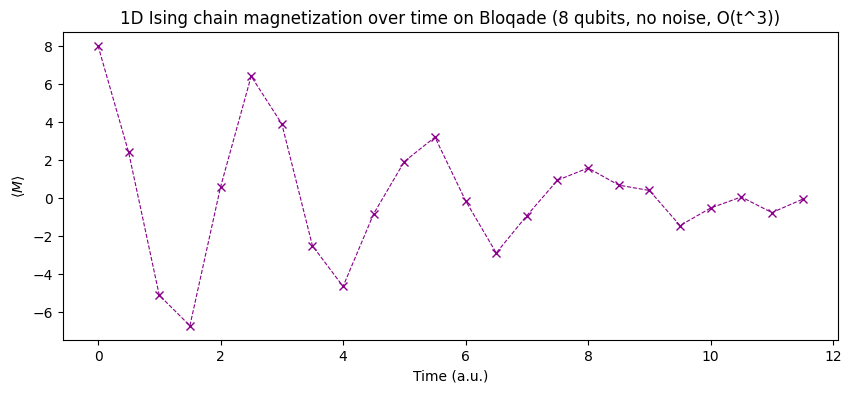

In [ ]:
plt.figure(figsize=(10, 4))
t = np.linspace(0, (steps-1)*time_interval, 24)
plt.plot(t, noNoise8QSukuzi, marker="x", c="darkmagenta", ls="dashed", lw=0.8)
plt.xlabel("Time (a.u.)")
plt.ylabel(r"$\langle M \rangle$")
plt.title("1D Ising chain magnetization over time on Bloqade (8 qubits, no noise, O(t^3))") 



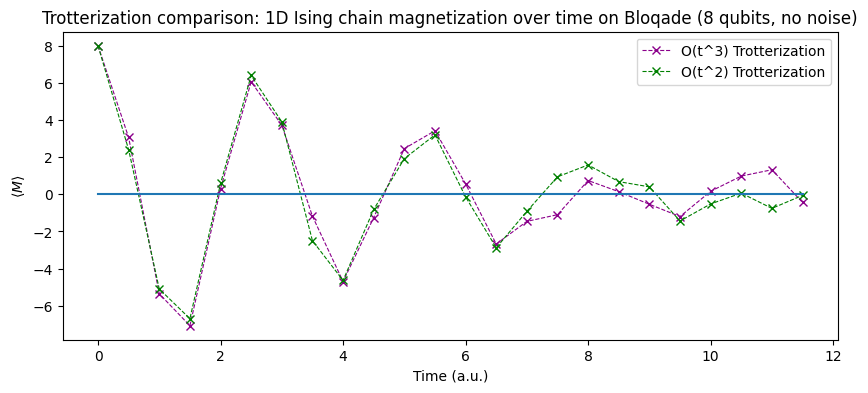

In [32]:
plt.figure(figsize=(10, 4))
t = np.linspace(0, (steps-1)*time_interval, 24)
plt.plot(t, noNoise8QSukuzi, marker="x", c="darkmagenta", ls="dashed", lw=0.8, label="O(t^3) Trotterization")
plt.plot(t, noNoise8QLie, marker="x", c="green", ls="dashed", lw=0.8, label="O(t^2) Trotterization")
plt.xlabel("Time (a.u.)")
plt.ylabel(r"$\langle M \rangle$")
plt.title("Trotterization comparison: 1D Ising chain magnetization over time on Bloqade (8 qubits, no noise)") 
plt.plot(t,np.zeros(24))
plt.legend()


[ 8.    2.4  -5.1  -6.7   0.58  6.4   3.9  -2.5  -4.64 -0.82  1.92  3.2
 -0.14 -2.88 -0.92  0.94  1.58  0.68  0.4  -1.44 -0.52  0.06 -0.76 -0.06]
[ 8.    2.4  -5.1  -6.7   0.58  6.4   3.9  -2.5  -4.64 -0.82  1.92  3.2
 -0.14 -2.88 -0.92  0.94  1.58  0.68  0.4  -1.44 -0.52  0.06 -0.76 -0.06]


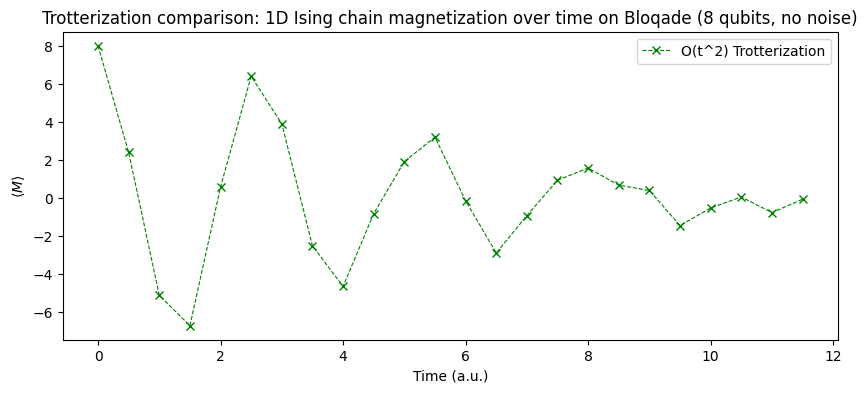

In [ ]:
plt.figure(figsize=(10, 4))
t = np.linspace(0, (steps-1)*time_interval, 24)
plt.plot(t, noNoise8QLie, marker="x", c="green", ls="dashed", lw=0.8, label="O(t^2) Trotterization")
plt.xlabel("Time (a.u.)")
plt.ylabel(r"$\langle M \rangle$")
plt.title("Trotterization comparison: 1D Ising chain magnetization over time on Bloqade (8 qubits, no noise)") 
plt.legend()


# Time Dependent Evolution

In [39]:
time_interval = 0.2
steps = 24
N = 3

# Time-dependent parameters (linear interpolation)
h_start, h_end = 0.5, 0.7  # Transverse field range
J_start, J_end = 0.7, 0.5  # Interaction strength range

mag_vals = []
time_vals = []

print("\nTime Evolution of Magnetization")
print("-----------------------------")
print("Time (t) | h(t) | J(t) | Magnetization (M)")
print("------------------------------------------")

for i in range(steps + 1):  # +1 to include t=0
    current_time = time_interval * i
    time_vals.append(current_time)
    
    # Calculate current h and J values (linear interpolation)
    t_frac = i / steps
    h = h_start + (h_end - h_start) * t_frac
    J = J_start + (J_end - J_start) * t_frac
    
    # Time-dependent Trotter evolution
    kernel_PT = SpinChainLieTrotterTD(
        n=N, 
        time=current_time, 
        steps=i if i > 0 else 1,  # Avoid division by zero
        h_start=h, h_end=h,  # Constant within this step
        J_start=J, J_end=J,
        parallelize=True
    )
    
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results = device.multi_run(kernel_PT, _shots=100)
    
    def to_bitstrings(results):
        return Counter(map(lambda result: "".join(map(str, result)), results))
    
    counts = to_bitstrings(results)
    
    total_magnetization = 0
    
    for key, value in counts.items():
        spin_down = key.count('1')
        total_magnetization += value * ( (2**N - 2*spin_down) / 2 )  # Simplified (-1/2 for 1, +1/2 for 0)
    
    avg_magnetization = total_magnetization / 100
    mag_vals.append(avg_magnetization)
    
    # Formatted output
    print(f"{current_time:.2f}     | {h:.2f} | {J:.2f} | {avg_magnetization:.3f}")

# Save results to a CSV file
import csv
with open('magnetization_results.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Time', 'h', 'J', 'Magnetization'])
    for t, h_val, J_val, m in zip(time_vals, 
                                 [h_start + (h_end-h_start)*(i/steps) for i in range(steps+1)],
                                 [J_start + (J_end-J_start)*(i/steps) for i in range(steps+1)],
                                 mag_vals):
        writer.writerow([f"{t:.2f}", f"{h_val:.2f}", f"{J_val:.2f}", f"{m:.3f}"])

print("\nResults saved to 'magnetization_results.csv'")


Time Evolution of Magnetization
-----------------------------
Time (t) | h(t) | J(t) | Magnetization (M)
------------------------------------------
0.00     | 0.50 | 0.70 | 4.000
0.20     | 0.51 | 0.69 | 4.000


ValueError: Cannot insert before a statement that is already in a block: constant